# 텍스트 분류 : 구분 → 책임구분류, 샘플링방식변경 : 랜덤샘플링

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
Okt = Okt()
kkma = Kkma()
hannanum = Hannanum()

In [3]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [4]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [5]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [6]:
df.shape

(8529, 17)

# null인 값 확인 및 제거

In [7]:
df_bak = df.copy()

In [8]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [9]:
df.shape

(8529, 17)

In [10]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [11]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [12]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [13]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

## 1-1대상선정) 'O'값 추출

In [14]:
dfo = df.loc[df['대상 선정']=='O',:] # 대상 선정값이 O 인 것만 가져오기 (X제외)
dfo.shape

(3012, 17)

## 1-2대상선정) 'X'값 추출

In [15]:
dfx = df.loc[df['대상 선정']=='X',:] # 대상 선정값이 X인 것만 가져오기 (O제외)
dfx.shape

(5517, 17)

##    2-1구분) '하체이음'값 추출 + 'X'값 더하기

In [16]:
df_hache1 = dfo.loc[dfo['구분']=='하체이음',:]
df_hache1.shape

(361, 17)

In [17]:
df_hache = pd.concat([df_hache1,dfx])
df_hache.shape

(5878, 17)

In [18]:
category_count1 = df_hache['책임구'].value_counts()
category_count1

N       5517
구매       249
생산공장     112
Name: 책임구, dtype: int64

## 2-2구분) '실내부품이음'값 추출 + 'X'값 더하기

In [19]:
df_silne1 = dfo.loc[dfo['구분']=='실내부품이음',:]
df_silne1.shape

(1050, 17)

In [20]:
df_silne = pd.concat([df_silne1,dfx])
df_silne.shape

(6567, 17)

In [21]:
category_count2 = df_silne['책임구'].value_counts()
category_count2

N       5517
구매       737
생산공장     299
연구소       14
Name: 책임구, dtype: int64

## 2-3구분) '기능(커넥터)'값 추출 + 'X'값 더하기

In [22]:
df_connect1 = dfo.loc[dfo['구분']=='기능(커넥터)',:]
df_connect1.shape

(1601, 17)

In [23]:
df_connect = pd.concat([df_connect1,dfx])
df_connect.shape

(7118, 17)

In [24]:
category_count3 = df_connect['책임구'].value_counts()
category_count3

N       5517
구매      1288
생산공장     313
Name: 책임구, dtype: int64

# '하체이음'값 '원인'분류 모델링

In [25]:
df_hache = df_hache.reindex()
df_silne = df_silne.reindex()
df_connect = df_connect.reindex()

# 전처리

In [26]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df_hache['charge_pred'] = df_hache['책임구'].astype(str).copy()
df_silne['charge_pred'] = df_silne['책임구'].astype(str).copy()
df_connect['charge_pred'] = df_connect['책임구'].astype(str).copy()

In [27]:
#명사 추출 함수
def nounextract(text):
    text = Okt.nouns(text)
    return text

In [28]:
df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(nounextract)

In [29]:
df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(nounextract)

In [30]:
df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(nounextract)

In [31]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text) # 특수문자 제거
    #text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)   # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)   # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)   # 한글, 영문만 남기고 모두 제거하도록 합니다.
    return text

In [32]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [33]:
%time df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(preprocessing)

Wall time: 161 ms


In [34]:
%time df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(preprocessing)

Wall time: 167 ms


In [35]:
%time df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(preprocessing)

Wall time: 188 ms


In [36]:
%time df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 467 ms


In [37]:
%time df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 530 ms


In [38]:
%time df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 577 ms


In [39]:
df_hache['clm_prtl_sbc'].head(10)

209          운행    가속    시    부르릉    소음    입    고함    ...
210             주행    가속    시    발생    및    진동    발생  ...
1554      로암    캠    볼트    불량    행시    딸그락딸그락    소음   ...
1570         이음    발생       연료    호스    램프    음부    차체...
1596         고속    주행    좌    커브    주행    시나    움벅    ...
1698         동시    소음    발생       및    조치    내용    시운 ...
1723         후진    시    운전    석    뒤    타이어    드럼    쪽...
2094         주행    정차    후진    시    타이어    뒤    회전    ...
3061         후진    시    소음    발생    점검    후진    시    브...
3063         후진    시    리    좌측    샤시    부분    뚜    둑 ...
Name: clm_prtl_sbc, dtype: object

In [40]:
df_silne['clm_prtl_sbc'].head(10)

15          테    게이트    트림    뜨르르르    이상    소음    발생 ...
40             주행    운전    석    시트    이       발생    점...
66       체인지    레버    레인지    레인지    변경    시    찍찍    ...
164              조립    불량    너트    창문    때    소리    발생  
171      브레이크    마스터    실린더    로드    브레이크    페달    연결...
179      행시    소음    시운전    및    점검    결과    테    게이트...
220         수석    시트    거림    점검    수석    리    마운틴   ...
227         리    슬라이딩    도어    레일    커버    소음    및   ...
255         프론트    필라    좌측    트림    교환    후    간섭   ...
274         주행    요철    부위    통과    시    및    선회    시...
Name: clm_prtl_sbc, dtype: object

In [41]:
df_connect['clm_prtl_sbc'].head(10)

12            인도    후    오디오    동시    주파수    및    노이...
14         주행    엔진    고등    점등    점검    내용    및    ...
19      사이드    에어백    고등    점등    컨넥터    체결    불량   ...
24                      작동       컨넥터    조립    재    조립  
25      어    라운드    뷰    장착       운전    석    미러    카...
32      리    윈도우    작동    불량    점검    시    뒤    운전  ...
38      운전    석    뒤    도어    유리창    작동    메인    파워 ...
58         와이퍼    스몰    등    후방    카메라    작동    불량  ...
63         출고    후    불량    내용    위       오디오    점검 ...
77         운전    석    뒤쪽    창문    리지    점검    의뢰    ...
Name: clm_prtl_sbc, dtype: object

# 학습데이터와 테스트데이터 만들기

In [42]:
df_hache = df_hache.reindex() #index 재설정. reindex:새로운 색인에 맞도록 객체를 새로 생성하는 기능.
df_silne = df_silne.reindex()
df_connect = df_connect.reindex()

In [43]:
df_hache.shape

(5878, 18)

In [44]:
df_silne.shape

(6567, 18)

In [45]:
df_connect.shape

(7118, 18)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
df_train_v_hache,df_test_v_hache = train_test_split(df_hache, test_size = 0.1, random_state=123)
df_train_v_silne,df_test_v_silne = train_test_split(df_silne, test_size = 0.1, random_state=123)
df_train_v_connect,df_test_v_connect = train_test_split(df_connect, test_size = 0.1, random_state=123)

In [48]:
df_train1 = df_train_v_hache.copy()
df_test1 = df_test_v_hache.copy()

In [49]:
df_train2 = df_train_v_silne.copy()
df_test2 = df_test_v_silne.copy()

In [50]:
df_train3 = df_train_v_connect.copy()
df_test3 = df_test_v_connect.copy()

In [51]:
df_train1.shape

(5290, 18)

In [52]:
df_test1.shape

(588, 18)

In [53]:
df_train2.shape

(5910, 18)

In [54]:
df_test2.shape

(657, 18)

In [55]:
df_train3.shape

(6406, 18)

In [56]:
df_test3.shape

(712, 18)

# 단어 벡터화

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['[C]']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 15970 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=15970, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=['[C]'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [104]:
#%%time 
train_feature_vector1 = vectorizer.fit_transform(df_train1['clm_prtl_sbc'])
train_feature_vector1.shape

(5290, 15970)

In [105]:
%%time 
test_feature_vector1= vectorizer.fit_transform(df_test1['clm_prtl_sbc'])
test_feature_vector1.shape

Wall time: 73 ms


In [106]:
#%%time 
train_feature_vector2 = vectorizer.fit_transform(df_train2['clm_prtl_sbc'])
train_feature_vector2.shape

(5910, 15970)

In [107]:
%%time 
test_feature_vector2= vectorizer.fit_transform(df_test2['clm_prtl_sbc'])
test_feature_vector2.shape

Wall time: 83 ms


In [108]:
#%%time 
train_feature_vector3 = vectorizer.fit_transform(df_train3['clm_prtl_sbc'])
train_feature_vector3.shape

(6406, 15970)

In [109]:
%%time 
test_feature_vector3= vectorizer.fit_transform(df_test3['clm_prtl_sbc'])
test_feature_vector3.shape

Wall time: 109 ms


In [110]:
vocab1 = vectorizer.get_feature_names()
print(len(vocab1))
vocab1[:10]

15970


['가까이',
 '가까이 드드득',
 '가까이 드드득 끼익',
 '가끔',
 '가끔 앞차',
 '가끔 앞차 가까이',
 '가끔 인식',
 '가끔 인식 점검',
 '가능',
 '가능 거리']

In [111]:
vocab2 = vectorizer.get_feature_names()
print(len(vocab2))
vocab2[:10]

15970


['가까이',
 '가까이 드드득',
 '가까이 드드득 끼익',
 '가끔',
 '가끔 앞차',
 '가끔 앞차 가까이',
 '가끔 인식',
 '가끔 인식 점검',
 '가능',
 '가능 거리']

In [112]:
vocab3 = vectorizer.get_feature_names()
print(len(vocab3))
vocab3[:10]

15970


['가까이',
 '가까이 드드득',
 '가까이 드드득 끼익',
 '가끔',
 '가끔 앞차',
 '가끔 앞차 가까이',
 '가끔 인식',
 '가끔 인식 점검',
 '가능',
 '가능 거리']

In [113]:
dist1 = np.sum(train_feature_vector1, axis=0)
dist1.shape

(1, 15970)

In [114]:
dist2 = np.sum(train_feature_vector2, axis=0)
dist2.shape

(1, 15970)

In [115]:
dist3 = np.sum(train_feature_vector3, axis=0)
dist3.shape

(1, 15970)

In [116]:
dist_pd1 = pd.DataFrame(dist1, columns=vocab1)
dist_pd1

가까이  가까이 드드득  가까이 드드득 끼익  가끔  가끔 앞차  가끔 앞차 가까이  가끔 인식  가끔 인식 점검   가능  \
0    7        7           2   6      4          9      2         3  185   

   가능 거리  ...    힌지 부위  힌지 부위 후드  힌지 수정  힌지 이음  힌지 이음 발생  힌지 장착  힌지 장착 불량  \
0      2  ...        6         2     39      3         4      4         2   

   힌지 조립  힌지 조립 불량  힌지 조정  
0      6         2      2  

[1 rows x 15970 columns]

In [117]:
dist_pd2 = pd.DataFrame(dist2, columns=vocab2)
dist_pd2

가까이  가까이 드드득  가까이 드드득 끼익  가끔  가끔 앞차  가끔 앞차 가까이  가끔 인식  가끔 인식 점검  가능  가능 거리  \
0    7        8           5   5     11          3    192         5   4      3   

   ...    힌지 부위  힌지 부위 후드  힌지 수정  힌지 이음  힌지 이음 발생  힌지 장착  힌지 장착 불량  힌지 조립  \
0  ...        3         4      8      4         4      6        41      3   

   힌지 조립 불량  힌지 조정  
0         4      6  

[1 rows x 15970 columns]

In [118]:
dist_pd3 = pd.DataFrame(dist3, columns=vocab3)
dist_pd3

가까이  가까이 드드득  가까이 드드득 끼익  가끔  가끔 앞차  가끔 앞차 가까이  가끔 인식  가끔 인식 점검  가능  가능 거리  \
0    7        7           4   5     13          4      4       183   3      3   

   ...    힌지 부위  힌지 부위 후드  힌지 수정  힌지 이음  힌지 이음 발생  힌지 장착  힌지 장착 불량  힌지 조립  \
0  ...        3         7      4      4         6     32         3      3   

   힌지 조립 불량  힌지 조정  
0         3      4  

[1 rows x 15970 columns]

In [119]:
dist_pd_t1 = dist_pd1.T
dist_pd_t1.head(10)

0
가까이           7
가까이 드드득       7
가까이 드드득 끼익    2
가끔            6
가끔 앞차         4
가끔 앞차 가까이     9
가끔 인식         2
가끔 인식 점검      3
가능          185
가능 거리         2

In [120]:
dist_pd_t2 = dist_pd2.T
dist_pd_t2.head(10)

0
가까이           7
가까이 드드득       8
가까이 드드득 끼익    5
가끔            5
가끔 앞차        11
가끔 앞차 가까이     3
가끔 인식       192
가끔 인식 점검      5
가능            4
가능 거리         3

In [121]:
dist_pd_t3 = dist_pd3.T
dist_pd_t3.head(10)

0
가까이           7
가까이 드드득       7
가까이 드드득 끼익    4
가끔            5
가끔 앞차        13
가끔 앞차 가까이     4
가끔 인식         4
가끔 인식 점검    183
가능            3
가능 거리         3

In [122]:
a1 = dist_pd_t1.sort_values(by=0, ascending = False)
a1.head(10)

0
램프 차이 확인   4930
제어기 통신 불가  4569
고속 행시      3250
그릴 볼트      2846
요구 작업장     2824
차출 뒤쪽      2706
발생 조치 내용   2438
확인 베어링 손상  2230
요철 작동      1665
관련 배선      1284

In [123]:
a2 = dist_pd_t2.sort_values(by=0, ascending = False)
a2.head(10)

0
런찬넬고무 이음    5970
조립 불량 흠집    5086
왼쪽 부위       3769
고등 고후       3769
굴곡 진도 행시    3338
채널 및런찬넬 교환  3056
범퍼          2595
확인 차체 진동    2421
요철 부분       2224
점검 의뢰 진단    1532

In [124]:
a3 = dist_pd_t3.sort_values(by=0, ascending = False)
a3.head(10)

0
조립 백도어 트립   6257
레일 동시       4924
고장 발생 설득    4296
발생 사이드      3663
차이 스크래치 발생  3337
남원 리모컨 삽입   2954
확인 업체       2868
어셈블리 교환 정상  2278
점검 조치 우측    1967
증상 개선 확인    1821

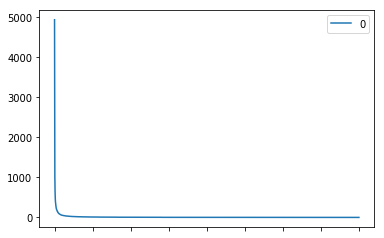

In [125]:
a1.plot()

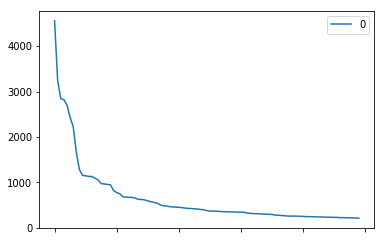

In [126]:
b1 = a1.iloc[1:100, :]
b1.plot()

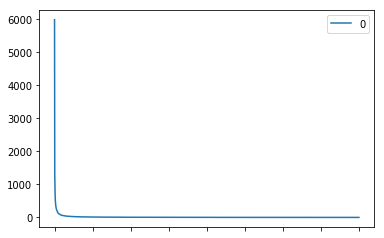

In [127]:
a2.plot()

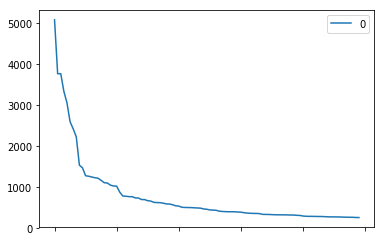

In [128]:
b2 = a2.iloc[1:100, :]
b2.plot()

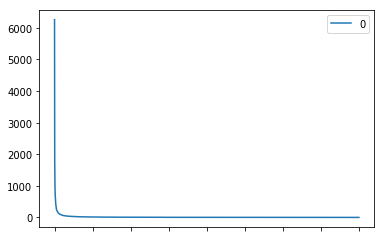

In [129]:
a3.plot()

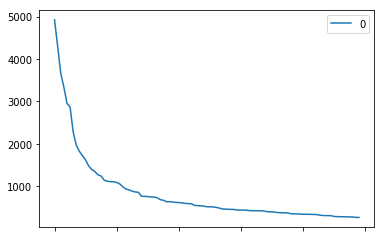

In [130]:
b3 = a3.iloc[1:100, :]
b3.plot()

# tf-idf 가중치 적용

In [131]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [132]:
#%%time 
train_feature_tfidf1 = transformer.fit_transform(train_feature_vector1)
train_feature_tfidf1.shape

(5290, 15970)

In [133]:
%%time 
test_feature_tfidf1 = transformer.fit_transform(test_feature_vector1)
test_feature_tfidf1.shape

Wall time: 6 ms


In [134]:
#%%time 
train_feature_tfidf2 = transformer.fit_transform(train_feature_vector2)
train_feature_tfidf2.shape

(5910, 15970)

In [135]:
%%time 
test_feature_tfidf2 = transformer.fit_transform(test_feature_vector2)
test_feature_tfidf2.shape

Wall time: 4 ms


In [136]:
#%%time 
train_feature_tfidf3 = transformer.fit_transform(train_feature_vector3)
train_feature_tfidf3.shape

(6406, 15970)

In [137]:
%%time 
test_feature_tfidf3 = transformer.fit_transform(test_feature_vector3)
test_feature_tfidf3.shape

Wall time: 7 ms


# 머신러닝 : 학습

In [138]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [139]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label1 = df_train1['charge_pred']
%time forest = forest.fit(train_feature_tfidf1, y_label1)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 452 ms


In [140]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label2 = df_train2['charge_pred']
%time forest = forest.fit(train_feature_tfidf2, y_label2)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 822 ms


In [141]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label3 = df_train3['charge_pred']
%time forest = forest.fit(train_feature_tfidf3, y_label3)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 987 ms


# 모델평가

In [142]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score1 = cross_val_score(forest, train_feature_vector1, y_label1, cv=k_fold, n_jobs=-1, scoring=scoring)
score1

Wall time: 3.86 s


array([0.94706994, 0.93478261, 0.94517958, 0.94517958, 0.94517958])

In [143]:
round(np.mean(score1)*100,2)

94.35

In [144]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score2 = cross_val_score(forest, train_feature_vector2, y_label2, cv=k_fold, n_jobs=-1, scoring=scoring)
score2

Wall time: 5.72 s


array([0.86379019, 0.87817259, 0.83248731, 0.85025381, 0.86632826])

In [145]:
round(np.mean(score2)*100,2)

85.82

In [146]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score3 = cross_val_score(forest, train_feature_vector3, y_label3, cv=k_fold, n_jobs=-1, scoring=scoring)
score3

Wall time: 5.71 s


array([0.87831513, 0.87119438, 0.8579235 , 0.8813427 , 0.88836846])

In [147]:
round(np.mean(score3)*100,2)

87.54

# 예측

In [148]:
# 테스트 데이터를 넣고 예측합니다.
y_pred1 = forest.predict(test_feature_vector1)
y_pred1[:3]

array(['N', 'N', 'N'], dtype=object)

In [149]:
y_pred1.shape

(588,)

In [150]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output1 = pd.DataFrame(data={'charge_pred':y_pred1})
output1.head(10)

charge_pred
0           N
1           N
2           N
3           N
4           N
5           N
6           N
7           N
8           N
9           N

In [151]:
df_test1['charge_pred'] = y_pred1

In [152]:
# 테스트 데이터를 넣고 예측합니다.
y_pred2 = forest.predict(test_feature_vector2)
y_pred2[:3]

array(['N', 'N', 'N'], dtype=object)

In [153]:
y_pred2.shape

(657,)

In [154]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output2 = pd.DataFrame(data={'charge_pred':y_pred2})
output2.head(10)

charge_pred
0           N
1           N
2           N
3           N
4           N
5           N
6           N
7           N
8           N
9           N

In [155]:
df_test2['charge_pred'] = y_pred2

In [156]:
# 테스트 데이터를 넣고 예측합니다.
y_pred3 = forest.predict(test_feature_vector3)
y_pred3[:3]

array(['N', 'N', 'N'], dtype=object)

In [157]:
y_pred3.shape

(712,)

In [158]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output3 = pd.DataFrame(data={'charge_pred':y_pred3})
output3.head(10)

charge_pred
0           N
1           N
2           N
3           N
4           N
5           N
6           N
7           N
8           N
9           N

In [159]:
df_test3['charge_pred'] = y_pred3

# 결과검증

In [160]:
df_test1['pred_diff'] = 0
df_test1['pred_diff'] = (df_test1['책임구'] == df_test1['charge_pred'] ) == 1
df_test1['pred_diff'] = df_test1['pred_diff'].astype(int)
df_test1.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd  \
1449               W  2015     20150618         ZZ3         B17   
865                W  2017     20170510         ZZ5         B13   
4028               W  2018     20180623         ZZ5         I3A   
217                W  2015     20150415         ZZ5         B11   
3302               W  2017     20170427         ZZ3         I12   

                ceq_psit_nm trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd  \
1449           조립 문제_정위치 불량         KV11          YP     A9          TT   
865             조립 문제_유격/유동         KV11          YP     A9          TT   
4028          경고등 점등_경고등 점등         KV11          YP     A9          AC   
217           조립 문제_미장착/오장착         KV11          YP     A9          CC   
3302  작동불량_작동이 원활하지 않음(무거움)         KV11          YP     A9          TT   

     repn_part_cd                                       clm_prtl_sbc 대상 선정 구분  \
1449        83185    슬라이딩    도어    자동    및    핀치    스트립    회로    ...     X  N   
865         89906    열    좌측    팔걸이    고정    볼트    캠    이탈    점검 ...     X  N   
4028        52933       타이어    기압    고등    점등       불만    점검    내...     X  N   
217         52937      타이어    캡    밸브    탈공    기압    점검    캡    밸브       X  N   
3302        82651       쪽    프론트    도어    아웃    사이드    핸들    버튼  ...     X  N   

     책임구 원인  검토결과 charge_pred  pred_diff  
1449   N  N  X---           N          1  
865    N  N  X---           N          1  
4028   N  N  X---           N          1  
217    N  N  X---           N          1  
3302   N  N  X---           N          1

In [161]:
diff_sum1 = df_test1['pred_diff'].sum()
diff_sum1

547

In [162]:
y_pred_len1 = len(y_pred1)
y_pred_len1

588

In [163]:
df_test2['pred_diff'] = 0
df_test2['pred_diff'] = (df_test2['책임구'] == df_test2['charge_pred'] ) == 1
df_test2['pred_diff'] = df_test2['pred_diff'].astype(int)
df_test2.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd  \
6060               W  2017     20170814         ZZ3         Q53   
6303               W  2017     20170911         ZZ3         Q53   
7375               W  2018     20180903         ZZ3         Q57   
5262               W  2016     20160929         ZZ4         Q22   
2775               W  2018     20180810         ZZ3         I11   

           ceq_psit_nm trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd  \
6060      소음/이음_요철로/둔턱         KV11          YP     A9          TT   
6303      소음/이음_요철로/둔턱         KV11          CK     J5          TT   
7375         소음/이음_작동시         KV11          YP     A9          TT   
5262  글라스 작동 소음/이음_하강시         KV11          YP     A9          TT   
2775         작동불량_작동안됨         KV11          YP     A9          CC   

     repn_part_cd                                       clm_prtl_sbc 대상 선정  \
6060        85820    주행    철도    및    도로    통과    시    따르르    거리 ...     O   
6303        82110       주행    소음    과    발생    건    점검    일전    도...     X   
7375        83950       슬라이딩    도어    동시    소리    점검    내용    및  ...     X   
5262        82540    윈도우    하강    시    끼익    소음    발생    밸    트라인...     O   
2775        97701       지금    갑자기    에어컨    찬    바람    이안    점검  ...     X   

          구분   책임구    원인                검토결과 charge_pred  pred_diff  
6060  실내부품이음  생산공장  조립불량  O-실내부품이음-생산공장-조립불량           N          0  
6303       N     N     N                X---           N          1  
7375       N     N     N                X---           N          1  
5262  실내부품이음    구매    부품      O-실내부품이음-구매-부품           N          0  
2775       N     N     N                X---           N          1

In [164]:
diff_sum2 = df_test2['pred_diff'].sum()
diff_sum2

553

In [165]:
y_pred_len2 = len(y_pred2)
y_pred_len2

657

In [166]:
df_test3['pred_diff'] = (df_test3['책임구'] == df_test3['charge_pred'] ) == 1
df_test3['pred_diff'] = df_test3['pred_diff'].astype(int)
df_test3.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd   ceq_psit_nm  \
6225               W  2017     20171201         ZZ3         Q53  소음/이음_요철로/둔턱   
739                W  2018     20180423         ZZ3         B12  조립 문제_들뜸/떨어짐   
1682               W  2017     20170526         ZZ2         B1A  조립 문제_이종품 장착   
7683               W  2018     20180828         ZZ5         Q57     소음/이음_작동시   
599                W  2016     20160909         ZZ5         B12  조립 문제_들뜸/떨어짐   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
6225         KV11          CK     J5          TT        92403   
739          KV11          YP     A9          TT        87382   
1682         KV11          YP     A9          TT        87210   
7683         KV11          YP     A9          TT        98360   
599          KV11          YP     A9          TT        86610   

                                           clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  \
6225       주행    요철    운행    시    트렁크    소음    발생   ...     X  N   N  N  X---   
739        슬라이딩    도어    커버    점검    및       육안    확...     X  N   N  N  X---   
1682       리    스포일러    중간    부위    오름       점검    도...     X  N   N  N  X---   
7683       와이퍼    동시    뿍뿍    뿍    소음    점검       와이...     X  N   N  N  X---   
599                    우측    리    범퍼    수정    작업    함       X  N   N  N  X---   

     charge_pred  pred_diff  
6225           N          1  
739            N          1  
1682           N          1  
7683           N          1  
599            N          1

In [167]:
diff_sum3 = df_test3['pred_diff'].sum()
diff_sum3

551

In [168]:
y_pred_len3 = len(y_pred3)
y_pred_len3

712

# 정확도

In [169]:
Acy1 = round(diff_sum1/y_pred_len1*100,1)
Acy1

93.0

In [170]:
Acy2 = round(diff_sum2/y_pred_len2*100,1)
Acy2

84.2

In [171]:
Acy3 = round(diff_sum3/y_pred_len3*100,1)
Acy3

77.4